# Mathematical Underpinnings - Lab 10

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [307]:
from sklearn.preprocessing import scale

In [308]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

## Task 1

In [309]:
df = pd.read_csv('prostate.data', sep="\t", index_col=0)

In [310]:
X = np.array(df.iloc[:, 0:8])
Y = np.array(df.iloc[:, 8])

In [311]:
X = scale(X)
Y = scale(Y)

### a)

In [312]:
mod_lars = Lars(fit_intercept=False)
# fit
mod_lars.fit(X, Y)

Lars(fit_intercept=False)

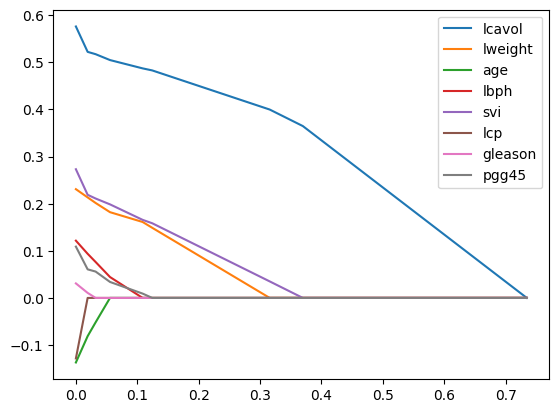

In [313]:
# plot
plt.figure()
plt.plot(mod_lars.alphas_, mod_lars.coef_path_.T)
plt.legend(df.columns[0:8], loc='upper right')
plt.show()


Order in which the variables are included in the model:

1. lcavol
2. svi
3. lweight
4. pgg45
5. lbph
6. age
7. gleason
8. lcp


### b)

In [314]:
mod_lars.alphas_

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])

### b1)

In [315]:
selected_variables = []

In [316]:
# identify the first variable (S1) selected by Lars, which is the one with the largest correlation with Y 
selected_variables = []
correlations = [np.corrcoef(X[:, i], Y)[0, 1] for i in range(X.shape[1])]
correlations = np.array(correlations)
selected_variables.append(np.argmax(np.abs(correlations)))
correlations

array([0.73446033, 0.43331938, 0.16959284, 0.1798094 , 0.56621822,
       0.54881317, 0.36898681, 0.42231586])

### b2)

In [317]:
mod1 = LinearRegression(fit_intercept=False)
mod1.fit(X[:, selected_variables], Y)
mod1.coef_

array([0.73446033])

### b3)

In [318]:
# code 
alphas = np.linspace(0, 1, 101)
y_hat = mod1.predict(X[:, selected_variables])

residuals_1 = np.zeros((len(Y), len(alphas)))
residuals_1 = Y[:, None] - alphas[None, :] * y_hat[:, None]
    

residual_correlations = np.zeros((X.shape[1], len(alphas)))

for i, alpha in enumerate(alphas):
    for j in range(X.shape[1]):
        residual_correlations[j, i] = np.corrcoef(X[:, j], residuals_1[:, i])[0, 1]
    
residual_correlations.shape

(8, 101)

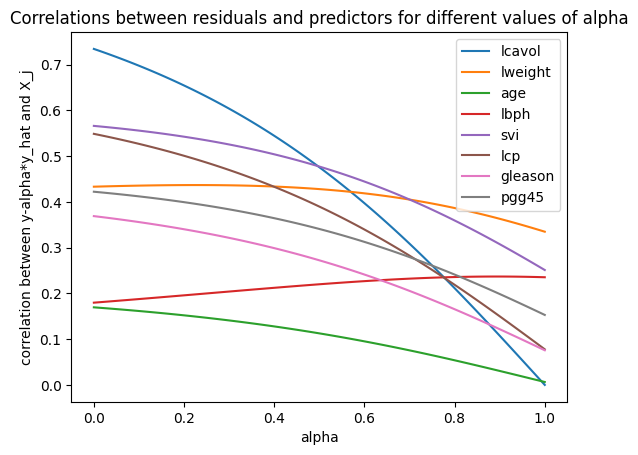

In [319]:
# plot

plt.figure()
plt.plot(alphas, residual_correlations.T)
plt.legend(df.columns[0:8], loc='upper right')
plt.title("Correlations between residuals and predictors for different values of alpha")
plt.xlabel("alpha")
plt.ylabel("correlation between y-alpha*y_hat and X_j")
plt.show()


The blue line corresponding to the `lcavol` variable is the one which visualizes the theorem.

### b4)

The `svi` variable will be included next, as this is the first one which crosses the blue one. The approximate alpha seems to be around 0.5.

### b5)

$$ \textrm{Cor}(Y - \tilde\alpha\hat Y, X_i) = ... \cdot\textrm{Cor}(Y, X_i) - ... \cdot \tilde\alpha \cdot \textrm{Cor}(\tilde\alpha\hat Y, X_i) $$

In our case, $i=0$, $j=4$:
$$ |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_i)| = |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_j)|$$

In [320]:
# code
values = np.zeros((X.shape[1], len(alphas)))

for i in range(X.shape[1]):  
    for j, alpha in enumerate(alphas):
        values[i, j] = np.std(Y)* np.corrcoef(X[:, i], Y)[0, 1] - np.std(y_hat)*alpha*np.corrcoef(X[:, i], y_hat)[0, 1]
        

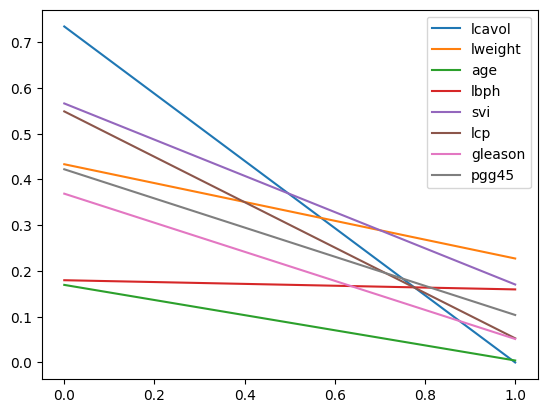

In [321]:
# plot

plt.plot(alphas, values.T)
plt.legend(df.columns[0:8], loc='upper right')
plt.show()

In [322]:
# which variable is chosen next

last_chosen_variable = selected_variables[-1]
new_chosen_variable = np.argmin((np.nan_to_num((np.std(Y)* np.corrcoef(X.T, Y)[selected_variables[-1], -1] - np.std(Y)* np.corrcoef(X.T, Y)[:-1, -1]) / (np.std(y_hat)* np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.std(y_hat)* np.corrcoef(X.T, y_hat)[:-1, -1]), nan = 1)))
new_chosen_variable



/tmp/ipykernel_12899/716470724.py:4: RuntimeWarning: invalid value encountered in divide
  new_chosen_variable = np.argmin((np.nan_to_num((np.std(Y)* np.corrcoef(X.T, Y)[selected_variables[-1], -1] - np.std(Y)* np.corrcoef(X.T, Y)[:-1, -1]) / (np.std(y_hat)* np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.std(y_hat)* np.corrcoef(X.T, y_hat)[:-1, -1]), nan = 1)))


4

In [323]:
a = np.std(Y) * np.corrcoef(X.T, Y)[last_chosen_variable, -1] - np.std(Y)* np.corrcoef(X.T, Y)[:-1,-1]
b = np.std(y_hat) * np.corrcoef(X.T, y_hat)[last_chosen_variable, -1] - np.std(y_hat)* np.corrcoef(X.T, y_hat)[:-1,-1]

gamma_2 = np.min(np.nan_to_num(a/b, nan = 1))
gamma_2

/tmp/ipykernel_12899/1059494610.py:4: RuntimeWarning: invalid value encountered in divide
  gamma_2 = np.min(np.nan_to_num(a/b, nan = 1))


0.4967289013871957

### b6)

In [324]:
alpha2 = np.std(Y)* np.corrcoef(X[:, new_chosen_variable], Y)[0, 1] - np.std(y_hat)*gamma_2*np.corrcoef(X[:, new_chosen_variable], y_hat)[0, 1]
alpha2

0.3696326552610745

In [325]:
Y = Y - y_hat*gamma_2

In [326]:
selected_variables.append(new_chosen_variable)
selected_variables

[0, 4]

### b7)

In [327]:
mod2 = LinearRegression(fit_intercept=False)

mod2.fit(X[:, selected_variables], Y)
mod2.coef_

array([0.24020136, 0.24020136])

### b8)

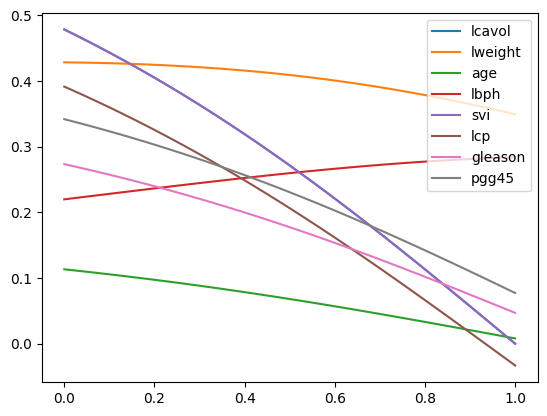

In [328]:
# code 
alphas = np.linspace(0, 1, 101)
y_hat = mod2.predict(X[:, selected_variables])

residuals = np.zeros((len(Y), len(alphas)))
for i, alpha in enumerate(alphas):
    residuals[:, i] = Y - alpha * y_hat
    

residual_correlations = np.zeros((X.shape[1], len(alphas)))

for i, alpha in enumerate(alphas):
    for j in range(X.shape[1]):
        residual_correlations[j, i] = np.corrcoef(X[:, j], residuals[:, i])[0, 1]


plt.plot(alphas, residual_correlations.T)
plt.legend(df.columns[0:8], loc='upper right')
plt.show()

The blue and purple lines (which are on top of each other) correspond `lcavol` and `svi` variables.

### b9)

Approximately 0.15

### b10)

In [329]:
values = np.zeros((X.shape[1], len(alphas)))

for i in range(X.shape[1]):  
    for j, alpha in enumerate(alphas):
        values[i, j] = np.std(Y)* np.corrcoef(X[:, i], Y)[0, 1] - np.std(y_hat)*alpha*np.corrcoef(X[:, i], y_hat)[0, 1]
        

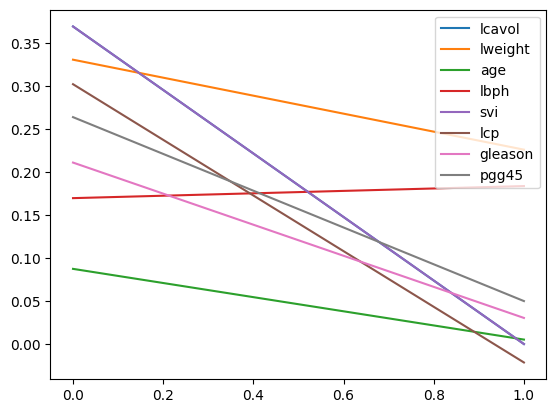

In [330]:

plt.plot(alphas, values.T)
plt.legend(df.columns[0:8], loc='upper right')
plt.show()

### b11)

In [331]:
# which variable is chosen next

last_chosen_variable = selected_variables[-1]
new_chosen_variable = np.argmin((np.nan_to_num((np.std(Y)* np.corrcoef(X.T, Y)[selected_variables[-1], -1] - np.std(r_1_alpha2)* np.corrcoef(X.T, r_1_alpha2)[:-1, -1]) / (np.std(y_hat)* np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.std(y_hat)* np.corrcoef(X.T, y_hat)[:-1, -1]), nan = 1)))
df.columns[new_chosen_variable]

/tmp/ipykernel_12899/1026098998.py:4: RuntimeWarning: divide by zero encountered in divide
  new_chosen_variable = np.argmin((np.nan_to_num((np.std(Y)* np.corrcoef(X.T, Y)[selected_variables[-1], -1] - np.std(r_1_alpha2)* np.corrcoef(X.T, r_1_alpha2)[:-1, -1]) / (np.std(y_hat)* np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.std(y_hat)* np.corrcoef(X.T, y_hat)[:-1, -1]), nan = 1)))


'svi'

In [332]:
a = np.std(Y) * np.corrcoef(X.T, Y)[last_chosen_variable, -1] - np.std(Y)* np.corrcoef(X.T, Y)[:-1,-1]
b = np.std(y_hat) * np.corrcoef(X.T, y_hat)[last_chosen_variable, -1] - np.std(y_hat)* np.corrcoef(X.T, y_hat)[:-1,-1]

gamma_3 = np.min(np.nan_to_num(a/b, nan = 1))
gamma_3

/tmp/ipykernel_12899/1182713106.py:4: RuntimeWarning: invalid value encountered in divide
  gamma_3 = np.min(np.nan_to_num(a/b, nan = 1))


0.14590879649354713

In [333]:
alpha3 = np.std(Y)* np.corrcoef(X[:, new_chosen_variable], Y)[0, 1] - np.std(y_hat)*gamma_3*np.corrcoef(X[:, new_chosen_variable], y_hat)[0, 1]
alpha3

0.3156999993872168

### c)

## Task 2

In [ ]:
X = pd.read_table("data/SRBCT_X.txt", sep=" ")
Y = pd.read_table("data/SRBCT_Y.txt", sep=" ")

X = np.array(X)
Y = np.array(Y)[:,0]

In [ ]:
X = scale(X)
Y = Y - np.mean(Y)

### a)

In [ ]:
mod_lars = Lars(n_nonzero_coefs=80)
# fit

In [ ]:
# plot

In [ ]:
# the order

### b)

In [ ]:
mod_lassolars = LassoLars(alpha=0.15)
# fit

In [ ]:
# order

In [ ]:
# plot

### c)

In [ ]:
lasso_coef = np.zeros((X.shape[1], mod_lassolars.alphas_.shape[0]))

In [ ]:
for i in range(mod_lassolars.alphas_.shape[0]):
    mod_lasso = Lasso(alpha=mod_lassolars.alphas_[i])
    mod_lasso.fit(X, Y)

    lasso_coef[:,i] = mod_lasso.coef_

In [ ]:
# plot